In [ ]:
df_price = df[
    [
        "product_id",
        "product_name",
        "brand_name",
        "primary_category",
        "secondary_category",
        "price_usd",
        "price_band",
        "loves_count",
        "rating",
        "reviews"
    ]
source
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- 0) Safety checks ----------
needed = ["primary_category", "price_band", "rating", "reviews", "product_id"]
missing = [c for c in needed if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns in df: {missing}")

d = df.copy()

# Make numeric and coerce price_band to Int64 when possible
d["rating"] = pd.to_numeric(d["rating"], errors="coerce")
d["reviews"] = pd.to_numeric(d["reviews"], errors="coerce")
d["price_band"] = pd.to_numeric(d["price_band"], errors="coerce").astype('Int64')

# Filter: require rating + reviews
d = d.dropna(subset=["primary_category", "price_band", "rating", "reviews"]).copy()

# Optional: ensure comparability (avoid tiny-review noise)
MIN_REVIEWS_PER_PRODUCT = 50
d = d[d["reviews"] >= MIN_REVIEWS_PER_PRODUCT].copy()

# ---------- 1) Summary table per category x price band ----------
summary = (
    d.groupby(["price_band", "primary_category"])
     .agg(
         products=("product_id", "nunique"),
         median_rating=("rating", "median"),
         mean_rating=("rating", "mean"),
         median_reviews=("reviews", "median")
     )
     .reset_index()
)

# ---------- 2) Winner per price band (by median_rating, tie-breaker: median_reviews, then products) ----------
summary_sorted = summary.sort_values(["price_band", "median_rating", "median_reviews", "products"], ascending=[True, False, False, False])
winners = summary_sorted.groupby('price_band', sort=True).first().reset_index()

print("Winner category per price band (highest median rating; min reviews>=50 per product):")
display(winners)

# ---------- 3) Count wins per category ----------
if winners.empty:
    print('No winners — check filters or data availability')
else:
    win_counts = winners['primary_category'].value_counts().reset_index()
    win_counts.columns = ['primary_category', 'price_band_wins']
    plt.figure(figsize=(9,4.5))
    sns.barplot(data=win_counts, x='primary_category', y='price_band_wins', order=win_counts['primary_category'])
    plt.title('How many price bands each category leads (highest median rating)')
    plt.xlabel('Primary Category')
    plt.ylabel('Number of price bands won')
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout()
    plt.show()

    # Quick statement check
    if (winners['primary_category'] == 'Makeup').all():
        print('✅ Makeup leads (best median rating) in ALL price bands, after filtering reviews>=50.')
    else:
        print('⚠️ Makeup does NOT lead in all price bands. See the winners table above.')


KeyError: "['price_band'] not in index"

In [ ]:
# Step 2 — Ensure numeric & clean rows
# Ensure numeric types
df_price["price_usd"] = pd.to_numeric(df_price["price_usd"], errors="coerce")
df_price["loves_count"] = pd.to_numeric(df_price["loves_count"], errors="coerce")
df_price["rating"] = pd.to_numeric(df_price["rating"], errors="coerce")
df_price["reviews"] = pd.to_numeric(df_price["reviews"], errors="coerce")

# Drop rows without essential data
df_price = df_price.dropna(subset=["price_usd", "loves_count", "rating"]) 

print("After cleaning:", df_price.shape)
df_price.head()


After cleaning: (8216, 9)


,product_id,product_name,brand_name,primary_category,secondary_category,price_usd,loves_count,rating,reviews
0,P473671,Fragrance Discovery Set,19-69,Fragrance,Value & Gift Sets,35.0,6320,3.6364,11.0
1,P473668,La Habana Eau de Parfum,19-69,Fragrance,Women,195.0,3827,4.1538,13.0
2,P473662,Rainbow Bar Eau de Parfum,19-69,Fragrance,Women,195.0,3253,4.2500,16.0
3,P473660,Kasbah Eau de Parfum,19-69,Fragrance,Women,195.0,3018,4.4762,21.0
4,P473658,Purple Haze Eau de Parfum,19-69,Fragrance,Women,195.0,2691,3.2308,13.0


In [ ]:
# Step 3 — Create 5 price bands (quantile-based)
df_price["price_band"] = pd.qcut(
    df_price["price_usd"],
    q=5,
    labels=False,
    duplicates="drop"
).astype("Int64")

# Check distribution
print("Products per price band:")
print(df_price["price_band"].value_counts().sort_index())


Products per price band:
price_band
0    1682
1    1747
2    1580
3    1592
4    1615
Name: count, dtype: Int64


In [ ]:
# Step 4 — Attach readable price ranges
price_band_ranges = (
    df_price
    .groupby("price_band")["price_usd"]
    .agg(
        min_price="min",
        median_price="median",
        max_price="max",
        count="count"
    )
    .reset_index()
)

price_band_ranges["price_range"] = (
    "$" + price_band_ranges["min_price"].round(2).astype(str)
    + " – $"
    + price_band_ranges["max_price"].round(2).astype(str)
)

price_band_ranges


,price_band,min_price,median_price,max_price,count,price_range
0,0,3.0,16.0,22.0,1682,$3.0 – $22.0
1,1,22.5,27.0,30.0,1747,$22.5 – $30.0
2,2,30.8,35.0,40.0,1580,$30.8 – $40.0
3,3,40.5,50.0,68.0,1592,$40.5 – $68.0
4,4,69.0,107.0,1900.0,1615,$69.0 – $1900.0


In [ ]:
MIN_REVIEWS = 50

df_price_fair = df_price[df_price["reviews"] >= MIN_REVIEWS].copy()

print("After enforcing minimum reviews:", df_price_fair.shape)


After enforcing minimum reviews: (5358, 10)


In [ ]:
least_expensive = (
    df_price_fair
    .sort_values("price_usd", ascending=True)
    .groupby(["primary_category", "price_band"])
    .head(1)
)

least_expensive[
    [
        "primary_category",
        "price_band",
        "product_name",
        "brand_name",
        "price_usd",
        "rating",
        "reviews",
        "loves_count"
    ]
]


,primary_category,price_band,product_name,brand_name,price_usd,rating,reviews,loves_count
6617,Skincare,0,Clean Charcoal Nose Strip,SEPHORA COLLECTION,3.00,3.0273,183.0,25388
6672,Mini Size,0,Mini Clean Cleansing & Gentle Exfoliating Wipes,SEPHORA COLLECTION,3.00,3.1961,51.0,6569
6550,Makeup,0,Organic Cotton Swabs,SEPHORA COLLECTION,3.00,4.4624,93.0,21081
6579,Tools & Brushes,0,Beauty on the Fly Reusable Bag,SEPHORA COLLECTION,4.95,4.7000,60.0,16473
6553,Hair,0,Clean Hair Sleeping Mask,SEPHORA COLLECTION,5.00,3.7544,57.0,20849
6521,Bath & Body,0,Moisturizing Body Lotion,SEPHORA COLLECTION,6.00,3.6887,106.0,26762
6786,Fragrance,0,Sephora Favorites Hello!— Beauty Game Changers,Sephora Favorites,10.00,4.0319,94.0,29399
3632,Men,0,Face Buff Energizing Scrub,Jack Black,20.00,4.7614,264.0,10670
4253,Makeup,1,Everlasting Lip Liner,KVD Beauty,22.50,4.5511,1655.0,153058
2613,Bath & Body,1,Butta Drop Whipped Oil Hydrating Body Cream Mini,Fenty Skin,23.00,4.1552,58.0,19707


In [ ]:
df_price_fair.groupby("price_band")["primary_category"].unique()
df_price_fair.groupby('price_band')['primary_category'].nunique().sort_index()
# izborjte koju primary categories ima 

price_band
0    8
1    8
2    8
3    8
4    7
Name: primary_category, dtype: int64

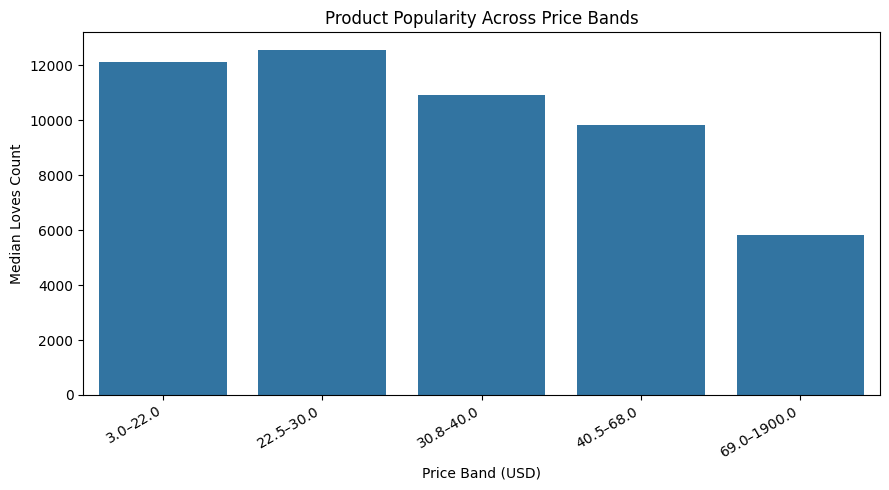

In [ ]:
#Median Loves by Price Band
plt.figure(figsize=(9,5))
sns.barplot(
    data=price_loves_summary,
    x="price_range",
    y="median_loves"
)

plt.title("Product Popularity Across Price Bands")
plt.xlabel("Price Band (USD)")
plt.ylabel("Median Loves Count")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
least_loved = (
    df_price_fair
    .sort_values("loves_count", ascending=True)
    .groupby(["primary_category", "price_band"])
    .head(1)
)

least_loved[
    [
        "primary_category",
        "price_band",
        "product_name",
        "brand_name",
        "price_usd",
        "rating",
        "reviews",
        "loves_count"
    ]
]


,primary_category,price_band,product_name,brand_name,price_usd,rating,reviews,loves_count
5854,Hair,3,Detox Shampoo,OUAI,64.0,4.5259,1352.0,0
2194,Skincare,0,Focuspot Blemish Micro Tip Patch,Dr. Jart+,20.0,3.9684,95.0,0
2895,Makeup,2,Rouge Interdit Vinyl Color Enhancing Lipstick ...,Givenchy,34.0,4.2557,176.0,0
4430,Makeup,1,ash Idôle Waterproof Mascara,Lancôme,30.0,4.4611,347.0,0
4512,Mini Size,1,Mini Translucent Loose Setting Powder - Honey,Laura Mercier,24.0,4.6503,386.0,0
5034,Hair,0,Mini 25 Miracle Milk Leave-In Conditioner,Mizani,13.5,4.4251,2171.0,0
2485,Skincare,3,Green Clean Makeup Meltaway Cleansing Balm Lim...,Farmacy,60.0,4.4958,6158.0,0
5150,Mini Size,0,Mini Color Care Conditioner,Moroccanoil,12.0,4.8480,171.0,163
5029,Hair,1,True Textures Coil Stretching & Styling Curl C...,Mizani,25.0,4.3900,100.0,196
1876,Skincare,4,Phyto Nature Oxygen Cream,Dermalogica,125.0,4.8646,192.0,274


In [ ]:
# remove loves count 0 products - They generate no engagement signal
df_price_fair = df_price_fair[df_price_fair["loves_count"] > 0].copy()


In [ ]:
df_fair = df_price.copy()

# Enforce reliability
df_fair = df_fair[df_fair["reviews"] >= 50]

# Drop zero loves
df_fair = df_fair[df_fair["loves_count"] > 0]

df_fair["loves_percentile"] = (
    df_fair
    .groupby(["primary_category", "price_band"])["loves_count"]
    .rank(pct=True)
)
least_loved_relative = df_fair[df_fair["loves_percentile"] <= 0.25]


In [ ]:
expensive_and_least_loved = (
    least_loved_relative
    .sort_values("price_usd", ascending=False)
    .groupby(["primary_category", "price_band"])
    .head(1)
)

expensive_and_least_loved[
    [
        "primary_category",
        "price_band",
        "product_name",
        "brand_name",
        "price_usd",
        "rating",
        "reviews",
        "loves_count",
        "loves_percentile"
    ]
]


,primary_category,price_band,product_name,brand_name,price_usd,rating,reviews,loves_count,loves_percentile
5546,Skincare,4,Trinity + Eye and Lip Enhancer Attachment Bundle,NuFACE,429.0,3.4381,105.0,4122,0.184492
7811,Fragrance,4,Tubéreuse Nue,TOM FORD,395.0,4.0117,426.0,4596,0.177928
4309,Hair,4,Limited Edition Barbie x Steampod Flat Iron & ...,L'Oreal Professionnel,250.0,4.2938,439.0,2867,0.153846
2209,Makeup,4,Platinum Long Lash Serum,Dr. Lara Devgan Scientific Beauty,150.0,4.4580,417.0,11182,0.192308
1771,Bath & Body,4,Eva Couples Vibrator,Dame,135.0,4.3893,131.0,2349,0.214286
3294,Skincare,3,Equilibrium Instant Plumping Eye Mask,Hourglass,68.0,4.4719,89.0,3935,0.114688
4552,Makeup,3,Aglow Golden Priming Oil,lilah b.,68.0,4.6207,58.0,4902,0.042553
5728,Hair,3,Hair Alchemy Strengthening Mask,Oribe,68.0,4.4251,247.0,2132,0.151163
7822,Fragrance,3,Ombré Leather Parfum Travel Spray,TOM FORD,65.0,4.3349,642.0,3637,0.170732
7186,Mini Size,3,Mini Concentrated Ginseng Renewing Serum,Sulwhasoo,65.0,4.6972,142.0,1471,0.200000


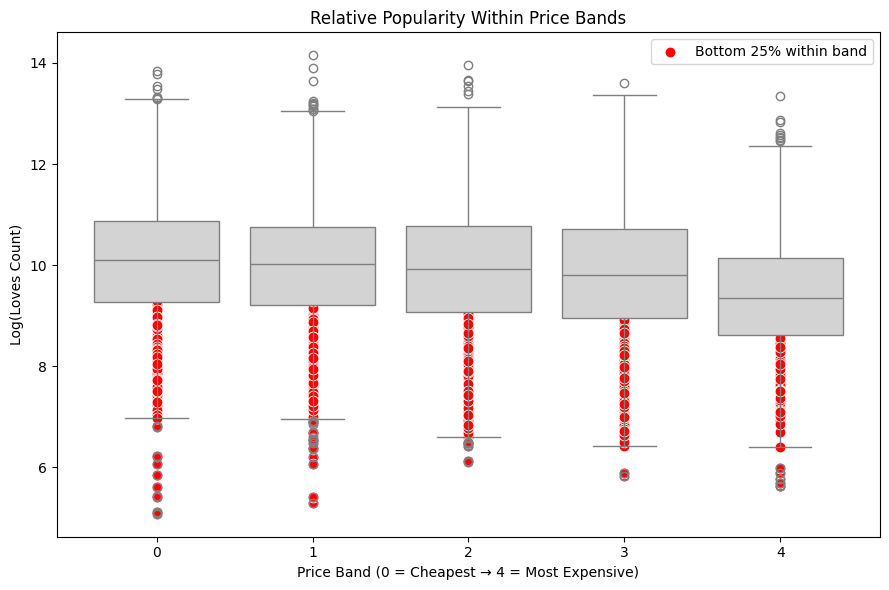

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Log-transform loves for fair comparison
df_fair["log_loves"] = np.log1p(df_fair["loves_count"])

plt.figure(figsize=(9, 6))

# Boxplot: distribution of popularity per price band
sns.boxplot(
    data=df_fair,
    x="price_band",
    y="log_loves",
    color="lightgray"
)

# Overlay least-loved (relative) products
sns.scatterplot(
    data=least_loved_relative,
    x="price_band",
    y=np.log1p(least_loved_relative["loves_count"]),
    color="red",
    label="Bottom 25% within band",
    s=60
)

plt.title("Relative Popularity Within Price Bands")
plt.xlabel("Price Band (0 = Cheapest → 4 = Most Expensive)")
plt.ylabel("Log(Loves Count)")
plt.legend()
plt.tight_layout()
plt.show()


primary_category,Bath & Body,Fragrance,Hair,Makeup,Men,Mini Size,Skincare,Tools & Brushes
price_band,,,,,,,,
0,53,13,145,415,4,109,293,16
1,42,85,270,544,10,36,190,8
2,38,102,244,405,4,7,292,1
3,58,41,172,282,1,5,497,1
4,14,444,78,52,1,0,374,3


,primary_categories
price_band,
0,"Bath & Body, Fragrance, Hair, Makeup, Men, Min..."
1,"Bath & Body, Fragrance, Hair, Makeup, Men, Min..."
2,"Bath & Body, Fragrance, Hair, Makeup, Men, Min..."
3,"Bath & Body, Fragrance, Hair, Makeup, Men, Min..."
4,"Bath & Body, Fragrance, Hair, Makeup, Men, Ski..."


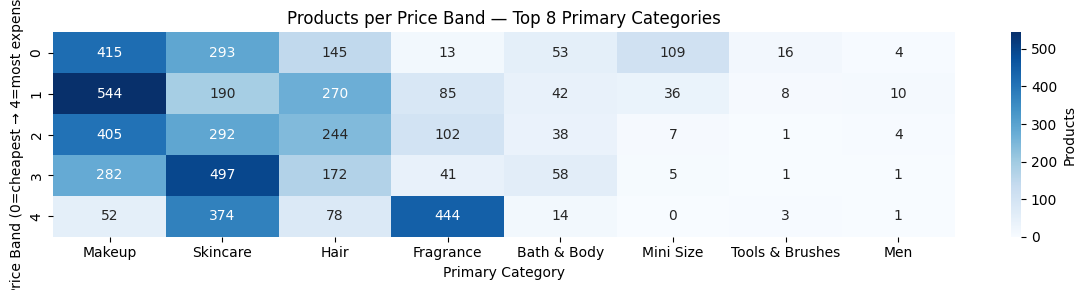

In [ ]:
# Table + heatmap of primary categories per price band (uses df_price_fair)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if 'df_price_fair' not in globals():
    raise NameError('df_price_fair not found — run the price-band cells first')

# 1) Count table: price_band × primary_category
counts = (
    df_price_fair
    .groupby(['price_band', 'primary_category'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

display(counts)

# 2) Compact list of categories per band for quick reading
categories_by_band = (
    df_price_fair
    .groupby('price_band')['primary_category']
    .unique()
    .apply(lambda arr: ', '.join(sorted([str(x) for x in arr])))
    .rename('primary_categories')
)

display(categories_by_band.to_frame())

# 3) Visual: heatmap of top categories (by total product count) to keep plot readable
top_n = 12
top_categories = df_price_fair['primary_category'].value_counts().nlargest(top_n).index.tolist()
counts_top = counts.reindex(columns=[c for c in top_categories if c in counts.columns]).fillna(0)

plt.figure(figsize=(12, max(3, 0.5 * counts_top.shape[0])))
sns.heatmap(counts_top, cmap='Blues', annot=True, fmt='d', cbar_kws={'label': 'Products'})
plt.title(f'Products per Price Band — Top {len(counts_top.columns)} Primary Categories')
plt.xlabel('Primary Category')
plt.ylabel('Price Band (0=cheapest → 4=most expensive)')
plt.tight_layout()
plt.show()


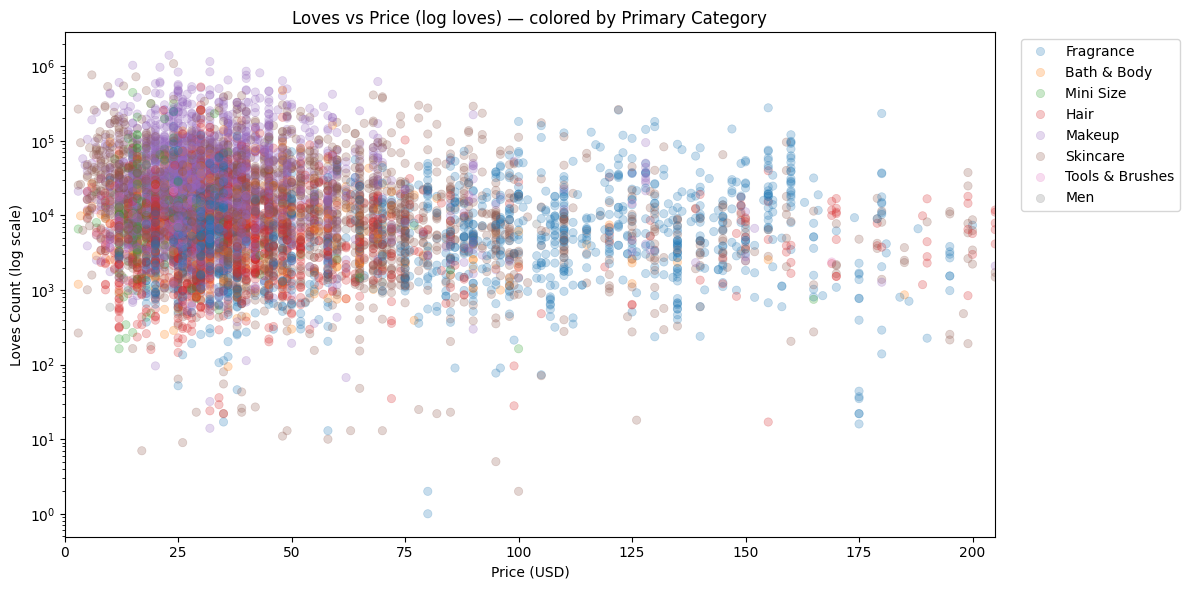

In [ ]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=dfp,
    x="price_usd",
    y="loves_count",
    hue="primary_category",
    alpha=0.25,
    edgecolor=None
)

plt.yscale("log")
plt.xlim(0, dfp["price_usd"].quantile(0.98))

plt.title("Loves vs Price (log loves) — colored by Primary Category")
plt.xlabel("Price (USD)")
plt.ylabel("Loves Count (log scale)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- 0) Safety checks ----------
needed = ["primary_category", "price_band", "rating", "reviews", "product_id"]
missing = [c for c in needed if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns in df: {missing}")

d = df.copy()

# Make numeric
d["rating"] = pd.to_numeric(d["rating"], errors="coerce")
d["reviews"] = pd.to_numeric(d["reviews"], errors="coerce")
d["price_band"] = pd.to_numeric(d["price_band"], errors="coerce")

# Filter: require rating + reviews
d = d.dropna(subset=["primary_category", "price_band", "rating", "reviews"]).copy()

# Optional: ensure comparability (avoid tiny-review noise)
MIN_REVIEWS_PER_PRODUCT = 50
d = d[d["reviews"] >= MIN_REVIEWS_PER_PRODUCT].copy()

# ---------- 1) Summary table per category x price band ----------
summary = (
    d.groupby(["price_band", "primary_category"])
     .agg(
         products=("product_id", "nunique"),
         median_rating=("rating", "median"),
         mean_rating=("rating", "mean"),
         median_reviews=("reviews", "median")
     )
     .reset_index()
)

# ---------- 2) Winner per price band (by median_rating, tie-breaker: median_reviews, then products) ----------
winners = (
    summary.sort_values(["price_band", "median_rating", "median_reviews", "products"], ascending=[True, False, False, False])
           .groupby("price_band")
           .head(1)
           .reset_index(drop=True)
)

print("Winner category per price band (good reviews = highest median rating, min reviews>=50 per product):")
display(winners)

# ---------- 3) “Makeup leads across all price bands?” — count wins ----------
win_counts = winners["primary_category"].value_counts().reset_index()
win_counts.columns = ["primary_category", "price_band_wins"]

plt.figure(figsize=(9,4.5))
sns.barplot(data=win_counts, x="primary_category", y="price_band_wins")
plt.title("How many price bands each category leads (highest median rating)")
plt.xlabel("Primary Category")
plt.ylabel("Number of price bands won")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

# Quick statement check:
if (winners["primary_category"] == "Makeup").all():
    print("✅ Makeup leads (best median rating) in ALL price bands, after filtering reviews>=50.")
else:
    print("⚠️ Makeup does NOT lead in all price bands. Here are the winners per band shown in the table above.")


KeyError: "Missing columns in df: ['price_band']"